In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [22]:
import matplotlib.pyplot as plt 

def plot_graph(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' +metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                         as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label, in train_dataset.take(1):
    print('text: ',example.numpy())
    print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [b"52-Pick Up never got the respect it should have. It works on many levels, and has a complicated but followable plot. The actors involved give some of their finest performances. Ann-Margret, Roy Scheider, and John Glover are perfectly cast and provide deep character portrayals. Notable too are Vanity, who should have parlayed this into a serious acting career given the unexpected ability she shows, and Kelly Preston, who's character will haunt you for a few days. Anyone who likes action combined with a gritty complicated story will enjoy this."
 b'This splendidly-directed fantasy is the second in the popular by flawed Tarzan series put out by MGM. It is a first-class adventure for many reasons, I suggest--fine photography, strong imaginative qualities, a delightful cast, good simulated-jungle locales and a very exciting storyline. Johnny Weissmuller plays Tarzan, a mono-syllabic untutored sort unlike Edgar Rice Burroughs\' creation; but he is honest, loyal, brave and very cou

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)

In [9]:
encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1,  58, 110, ...,   0,   0,   0],
       [ 11,   1, 996, ...,   0,   0,   0],
       [ 11,  18,  44, ...,   0,   0,   0]])

In [12]:
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

Original:  b"52-Pick Up never got the respect it should have. It works on many levels, and has a complicated but followable plot. The actors involved give some of their finest performances. Ann-Margret, Roy Scheider, and John Glover are perfectly cast and provide deep character portrayals. Notable too are Vanity, who should have parlayed this into a serious acting career given the unexpected ability she shows, and Kelly Preston, who's character will haunt you for a few days. Anyone who likes action combined with a gritty complicated story will enjoy this."
Round-trip:  [UNK] up never got the [UNK] it should have it works on many [UNK] and has a [UNK] but [UNK] plot the actors involved give some of their [UNK] performances [UNK] [UNK] [UNK] and john [UNK] are perfectly cast and [UNK] deep character [UNK] [UNK] too are [UNK] who should have [UNK] this into a serious acting career given the [UNK] [UNK] she shows and [UNK] [UNK] whos character will [UNK] you for a few days anyone who [UNK]

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [15]:
sample_text = ('The movie was cool. it was awesome.')
prediction = model.predict(np.array([sample_text]))
print(prediction[0])

[0.02005088]


In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.02005089]


In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.Adam(1e-4),
             metrics=['accuracy'])

In [18]:
history = model.fit(train_dataset, epochs = 10,
                   validation_data = test_dataset,
                   validation_steps=30)

Epoch 1/10
391/391 [==============================] - 38s 86ms/step - loss: 0.6867 - accuracy: 0.5103 - val_loss: 0.5734 - val_accuracy: 0.6615
Epoch 2/10
391/391 [==============================] - 32s 82ms/step - loss: 0.5050 - accuracy: 0.7393 - val_loss: 0.3854 - val_accuracy: 0.8344
Epoch 3/10
391/391 [==============================] - 34s 86ms/step - loss: 0.3546 - accuracy: 0.8406 - val_loss: 0.3449 - val_accuracy: 0.8599
Epoch 4/10
391/391 [==============================] - 32s 82ms/step - loss: 0.3267 - accuracy: 0.8573 - val_loss: 0.3281 - val_accuracy: 0.8583
Epoch 5/10
391/391 [==============================] - 32s 83ms/step - loss: 0.3162 - accuracy: 0.8649 - val_loss: 0.3277 - val_accuracy: 0.8411
Epoch 6/10
391/391 [==============================] - 33s 84ms/step - loss: 0.3082 - accuracy: 0.8691 - val_loss: 0.3213 - val_accuracy: 0.8474
Epoch 7/10
391/391 [==============================] - 33s 83ms/step - loss: 0.3041 - accuracy: 0.8691 - val_loss: 0.3262 - val_accuracy:

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss} ||| Test Accuracy: {test_acc}')

391/391 [==============================] - 13s 33ms/step - loss: 0.3157 - accuracy: 0.8641
Test Loss: 0.3157292902469635 ||| Test Accuracy: 0.864080011844635


(0.0, 0.680811484158039)

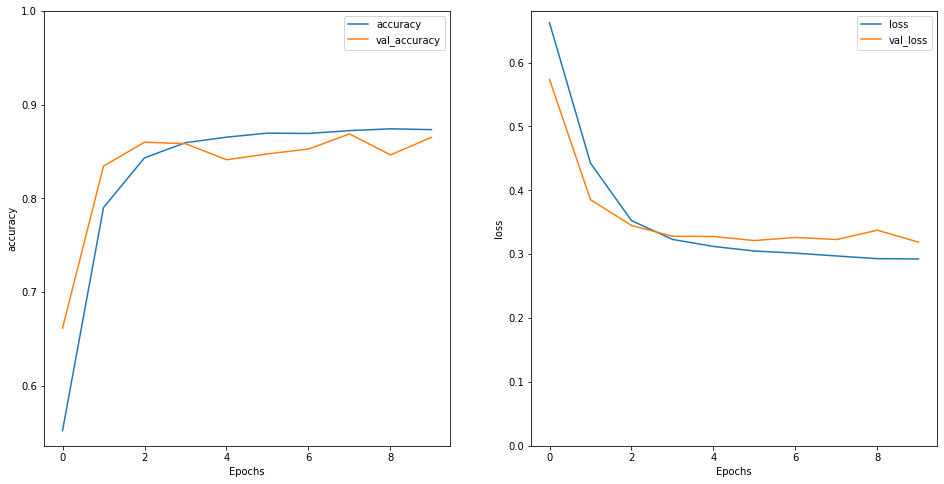

In [24]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graph(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graph(history, 'loss')
plt.ylim(0, None)

In [39]:
sample_text = ('the movie was well scripted')
prediction = model.predict(np.array([sample_text]))
print(prediction[0])

[0.4458742]
